In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error,mean_absolute_error
path = "Results/energy/robust/energy_ip_336_op_168_nhead_4_mask_1_options_all_without_augument_dow_6/energy/"
preds = np.load(path+'trans-nll-ar_pred_mu.npy')
inputs = np.load(path+'inputs.npy')
trues = np.load(path+'targets.npy')
#preds = preds.reshape(-1, preds.shape[-2], preds.shape[-1])
#trues = trues.reshape(-1, preds.shape[-2], preds.shape[-1])
# [samples, pred_len, dimensions]
print(preds.shape, trues.shape, inputs.shape)

print("mse : ",mean_squared_error(trues.squeeze(),preds.squeeze()),"mae: ",mean_absolute_error(trues.squeeze(),preds.squeeze()))

(10, 168, 1) (10, 168, 1) (10, 336, 1)
mse :  10319.887 mae:  61.250767


In [12]:
# x = preds.reshape(54,13,-1,1)
# preds = x.mean(axis=1)
# preds.shape
# x = trues.reshape(54,13,-1,1)
# trues = x.mean(axis=1)
# trues.shape

# print("mse : ",mean_squared_error(trues.squeeze(),preds.squeeze()),"mae: ",mean_absolute_error(trues.squeeze(),preds.squeeze()))

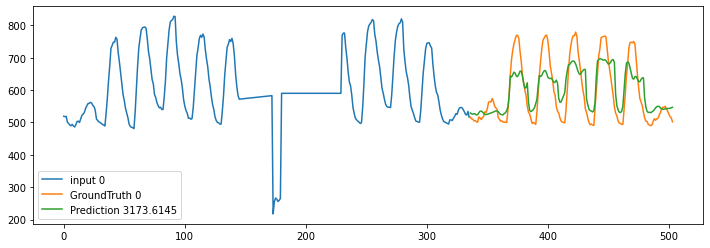

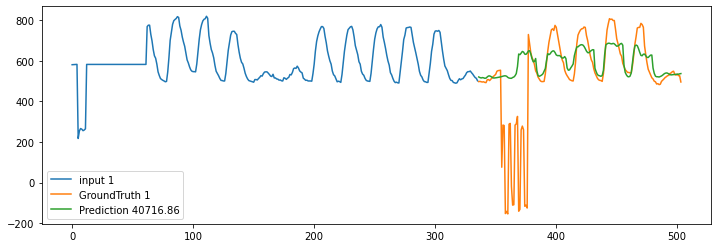

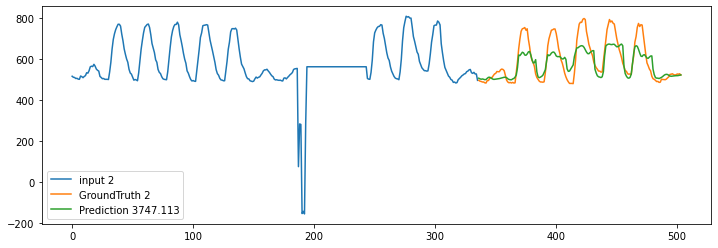

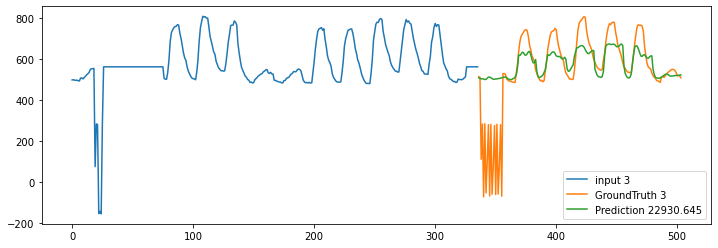

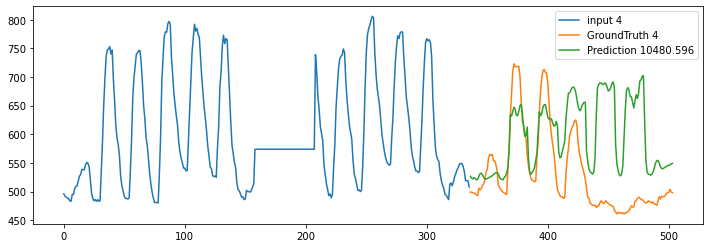

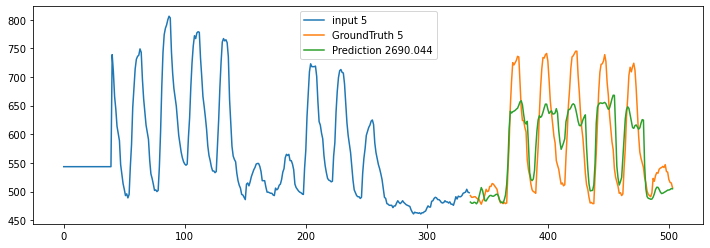

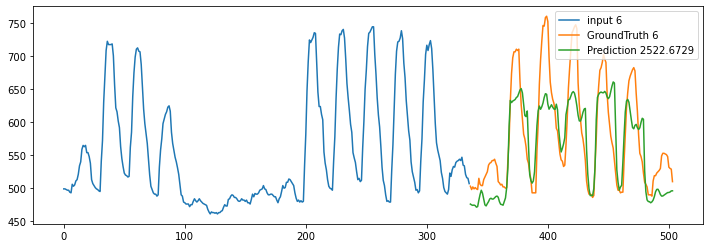

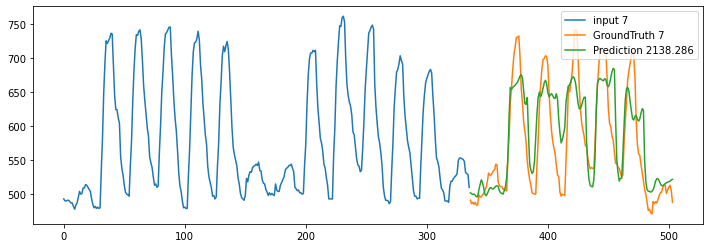

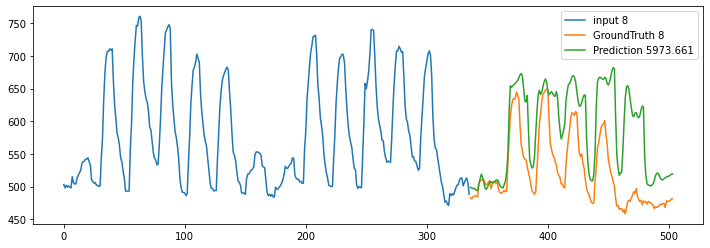

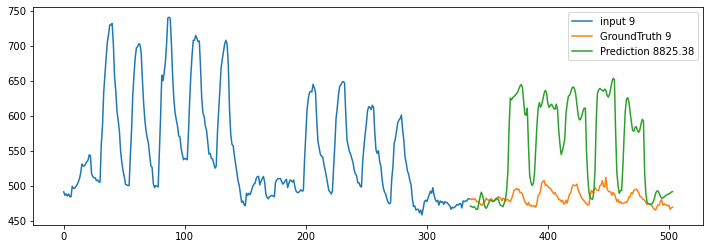

In [13]:
plt.rcParams['figure.figsize'] = (12,4)
x = np.arange(inputs.shape[1]+preds.shape[1])
a = inputs.shape[1]

for i in range(inputs.shape[0]):
    plt.figure()
    c =i 
    plt.plot(x[:a],inputs[c],label='input '+str(c))
    plt.plot(x[a:],trues[c,:,0], label='GroundTruth '+str(c))
    #for i in range(1):

    plt.plot(x[a:],preds[c,:,0], label='Prediction '+str(mean_squared_error(preds[c,:,0],trues[c,:,0])))
    
    plt.legend()
    # fig = plt.figure()
    # plt.savefig("images/trans-mse_test_"+str(i)+".png")
    
    # plt.show()

In [7]:
preds_original = np.load("Results/march/Outputs/Output_original_point_0.2_per/electricity/"+'TRANS-MSE-AR_pred_mu.npy')
preds_train = np.load("Results/march/Outputs/Output_synthetic_train_point_0.2_per/electricity/"+'TRANS-MSE-AR_pred_mu.npy')
preds_test = np.load("Results/march/Outputs/Output_synthetic_test_point_0.2_per/electricity/"+'TRANS-MSE-AR_pred_mu.npy')
preds_both = np.load("Results/march/Outputs/Output_synthetic_both_point_0.2_per/electricity/"+'TRANS-MSE-AR_pred_mu.npy')
trues = np.load("Results/march/Outputs/Output_original_point_0.2_per/electricity/"+'targets.npy')


In [ ]:
print("original\t\ttrain\t\ttest\t\tboth")
for i in range(len(trues)):
    print(f"{mean_squared_error(trues.squeeze()[i,:],preds_original.squeeze())[i,:]:0.2f}, {mean_squared_error(trues.squeeze()[i,:],preds_train.squeeze()[i,:]):0.2f}, {mean_squared_error(trues.squeeze()[i,:],preds_test.squeeze()[i,:]):0.2f}, {mean_squared_error(trues.squeeze()[i,:],preds_both.squeeze()[i,:]):0.2f}")

In [3]:
import torch
ex_mask = torch.tensor([1,1,0,0,1],dtype=bool)
print(ex_mask)
# ex_mask = attn_mask.masked_fill(ex_mask==True,value=True)
# print(ex_mask)

tensor([ True,  True, False, False,  True])


In [ ]:
ex_mask = torch.tensor(ex_mask,dtype=bool)
head1 = ex_mask * ex_mask.unsqueeze(-1)
head2 = torch.zeros_like(head1)==1
ex = torch.stack((head1,head2))
# ex_mask = torch.tensor(ex,dtype=bool)
print(ex)

In [27]:

x= np.random.randn(3,5,13)
ds = np.array([np.repeat([[1,1,1,1]],5,axis=0),np.repeat([[2,2,2,2]],5,axis=0),np.repeat([[3,3,3,3]],5,axis=0)])

In [30]:
plt.rcParams['figure.figsize']=(20,5)
DATA_DIRS = '/mnt/cat/data/sandy/Forecasting/'
df = pd.read_csv(
    os.path.join(DATA_DIRS, 'data', 'electricity_load_forecasting_panama', 'continuous_dataset.csv')
)
df_inject   = pd.read_csv(
    os.path.join(DATA_DIRS, 'data', 'electricity_load_forecasting_panama', '2_percent_electricity.csv')
)
df_mask   = pd.read_csv(
    os.path.join('.', 'data', 'masked_reduced.csv')
)


test_data = np.load(os.path.join(DATA_DIRS,"Outliers","Outlier","data","new_masked.npy"))
test_l = len(test_data)
data = df[['nat_demand']].to_numpy().T
data_inj = df_inject[['nat_demand']].to_numpy().T
data_mask = df_inject[['label']].to_numpy().T

# data_inj = data
#n = data.shape[1]
n = (1903 + 1) * 24 # Select first n=1904*24 entries because of non-stationarity in the data after first n values
data = data[:, :n]
data_inj = data_inj[:, :n]
data_mask = data_mask[:, :n]
df = df.iloc[:n]
N_output = 168
# set_trace()
units = n//N_output
dev_len = int(0.2*units) * N_output
test_len = int(0.2*units) * N_output
train_len = n - dev_len - test_len

### generated masking
data_mask[...,train_len+dev_len-N_output:-N_output] = test_data 

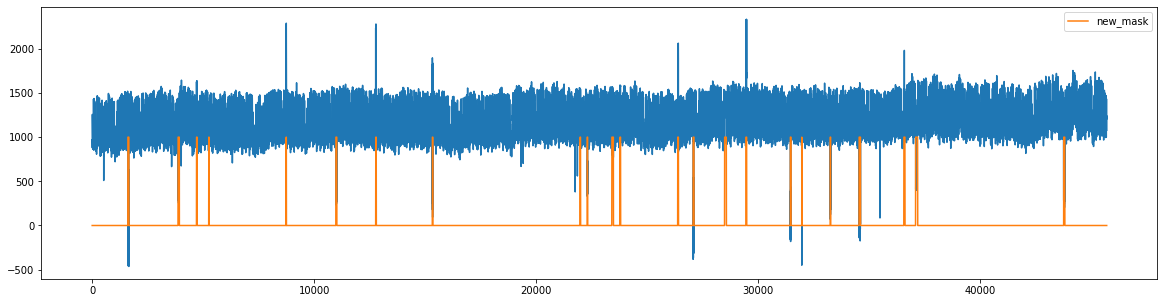

In [34]:
test_data = np.load(os.path.join(DATA_DIRS,"Outliers","Outlier","data","new_masked.npy"))
data_mask[...,train_len+dev_len-N_output:-N_output] = test_data
plt.plot(data_inj[0,:])
# plt.plot(np.array(test_data).reshape(-1,)*1000)
plt.plot(data_mask[0,:]*1000,label="new_mask")
plt.legend()
plt.show()


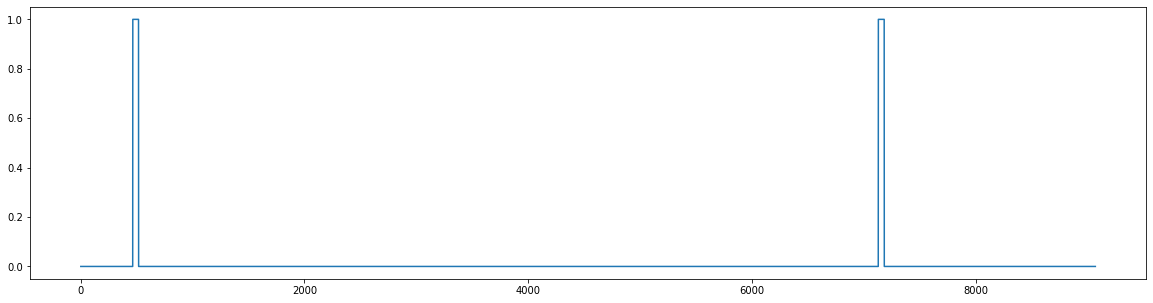

In [16]:
plt.plot(data_mask[-test_len:])

In [7]:
DATA_DIRS = "/mnt/a99/d0/sandy/Forecasting/"
df = pd.read_csv(DATA_DIRS+'data/energy-anomaly-detection/train.csv')

df = df[df['building_id']==966].interpolate(limit_direction='both',method='linear')
data = df[['meter_reading']].to_numpy()
# # set_trace()
# data_mask = df[['anomaly']].to_numpy().T

df = pd.read_csv(DATA_DIRS+'data/energy-anomaly-detection/energy_injected_5.csv')
data_inj = df[['meter_reading']].to_numpy() 
data_mask = df[['anomaly']].to_numpy().T

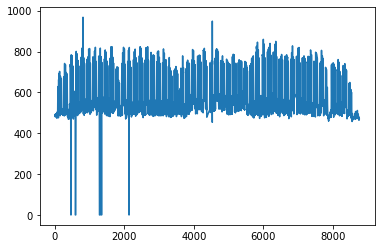

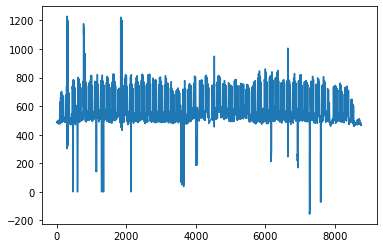

In [11]:
plt.plot(data)
plt.show()
plt.plot(data_inj)
plt.show()